# Collaborative Filtering - Matrix Factorization
In this Notebook, we will be performing collaborative filtering using matrix factorization. The steps we will follow are detailed in the introduction. We will be using TensorFlow as our ML framework for the development of our music recommender system. Let's begin by importing our packages, and building a sparse representation of our ratings matrix.

In [1]:
import pandas as pd
import numpy as np
import tensorflow.compat.v1 as tf
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
import sklearn
import sklearn.manifold
from matplotlib import pyplot as plt
tf.compat.v1.disable_eager_execution()

We are importing a range of helper functions in the below cell. These functions are defined in `CFUtils.py`, and `CFModel.py`, both of which can be found in the [Github Repository](https://github.com/scummins00/CA4015-Music-RecSystem) for this assignment.

In [2]:
#Let's import our helper functions defined externally
from CFUtils import build_rating_sparse_tensor, split_dataframe, sparse_mean_square_error, build_model, item_neighbors, user_recommendations
from CFModel import CFModel

ModuleNotFoundError: No module named 'seaborn'

In [3]:
# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
    """Returns a filtered dataframe, by applying function to key"""
    return df[function(df[key])]

def flatten_cols(df):
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

## Feature Engineering
In the following cells, we will be re-mapping our user ID's to fit into a scale that is defined as $[0, m]$, where $m$ is our number of unique users. Currently, despite there being only 1,892 unique users, profiles exist with ID's such as 1,893, 2,000, and so on. This is an issue because when we generate our ratings matrix, we will be creating rows that do not represent any users. Mapping our user ID's to a suitable scale is good practice and will avoid issues in the future.

The case is the same for artist ID's with them not being presented in a contiguous order. We will apply the same principal above to remap our artist ID's to the correct scale.

In [178]:
#Let's define our amount of users
rating_matrix = pd.read_csv('../data/user_artists.dat', sep='\t', encoding='latin-1')
num_users = len(rating_matrix.userID.unique())

#Extract userID column
userids = np.asarray(rating_matrix.userID)

#Remap the column
u_mapper, u_ind = np.unique(userids, return_inverse=True)

In [179]:
#Let's define our amount of artists
artists = pd.read_csv('../data/artists.dat', sep='\t', encoding='latin-1')
artists.rename(columns={'id':'artistID'}, inplace=True)
num_artists = len(artists.artistID.unique())

#Extract artistID column
artistids = np.asarray(rating_matrix.artistID)

#Remap the column
a_mapper, a_ind = np.unique(artistids, return_inverse=True)

In [180]:
#Assert that u_ind and userID column are of same size
assert(len(u_ind) == len(rating_matrix.userID))

#Assert that a_ind and artistID column are of same size
assert(len(a_ind) == len(rating_matrix.artistID))

In [181]:
# Let's replace old columns with new ind ones
rating_matrix.userID = u_ind
rating_matrix.artistID = a_ind

#Let's ensure the max value is approriate
assert(rating_matrix.userID.unique().max() == 1891)
assert(rating_matrix.artistID.unique().max() == 17631)

## The Problem With Rating Values
For this collaborative filtering model, I would have liked to make use of the explicit rating data available in the 'weight' column of the ratings matrix. Through trial and error, I've come to the conclusion that using this data explicitly will not create an effective recommendation system.

The reason for this is to do with the the distribution of user to artist listens. Many user to artist combinations have only a value of 1 for the 'weight' column. When aggregating the total listens for artists by summing the weights, we see a huge portion of the artists still only have 1 or so listens, whilst popular artists such as Katy Perry, Lady Gaga, and Britney Spears, can accumulate millions of listens, Britney Spears coming out on top with 2.4 million listens from users in this dataset. This problem is known as the *Long Tail Problem* {cite}`anderson2006long`.

Intuitively, this is not suitable for a recommendation system because in this case if we ignore the outliers, we are ignoring the most important features of the dataset. Normalising our 'weight' column has little-to-no effect on performance as squashing such disparate values into a smaller range does not fix the disparity.

Another approach is to use a binary representation of the ratings matrix. If a user has ever listened to an artist, the 'listened' column receives a value of 1. Otherwise, the value is 0. This approach does result in some information loss, as we are no longer aware of how regular of a listener a user is to a particular artist.

In [182]:
#We're going to make a binary representation of the matrix. If the user ever listened to the artist, they get a value of 1. 0 otherwise
rating_matrix['listened'] = 1.0

In [183]:
rating_matrix.describe()

,userID,artistID,weight,listened
count,92834.000,92834.000,92834.000,92834.000
mean,944.222,3235.737,745.244,1.000
std,546.751,4197.217,3751.322,0.000
min,0.000,0.000,1.000,1.000
25%,470.000,430.000,107.000,1.000
50%,944.000,1237.000,260.000,1.000
75%,1416.000,4266.000,614.000,1.000
max,1891.000,17631.000,352698.000,1.000


### Adding Genres to Artists
For visualisating our recommendations, we will view the dispersion of genres in latent space. This will allow us to understand if music of similar genres generally cluster around each other. For this, we would like to be able to join our artists and genres tables.

We must firstly merge the `tags.dat` data with the `user_taggedartists.dat` data. We then `groupby` artist name and use a lambda function to list the genres for that artist. It should be noted that `user_taggedartists.dat` is user-generated information, and therefore may contain some innacurate or unimportant artist tags. To counteract this, we will only be including a tag as part of the artists genre if it has been associated with that artist on 3 or more seperate occasions.

In [184]:
#Let's read in genres and tags
genres = pd.read_csv('../data/tags.dat', sep='\t', encoding='latin-1')
artists_tagged = pd.read_csv('../data/user_taggedartists.dat', sep='\t', encoding='latin-1')

In [185]:
#Let's match artists to genres
artists_tagged = artists_tagged.merge(genres[['tagID', 'tagValue']], on='tagID')
artists_tagged = (artists_tagged.groupby('artistID')['tagValue'].apply(lambda grp: list(grp))).reset_index()

We know that as tags are applied by users, they can be innaccurate and messy. In the following cell we perform these actions:
1. Loop through each artist in our `artists_tagged` table
1. Create a dictionary for that artist's tags
1. Count the tags using the dictionary
1. Order the artist tags by number of appearances and save them in a `new_tags` variable.
1. The artist receives the `new_tags` variable ("No Tags" string if list is empty.)

In [186]:
for index, row in artists_tagged.iterrows():
    d = {}
    new_tags = []
    for val in row.tagValue:
        if val not in d:
            d[val] = 1
        else:
            d[val] += 1
    for key, value in d.items():
        if d[key] >=3:
            new_tags.append([key, value])
    new_tags.sort(key=lambda x:x[1], reverse=True)
    if new_tags:
        artists_tagged.at[index, "tagValue"] = [tag[0] for tag in new_tags]
        artists_tagged.at[index, 'genre'] = artists_tagged.at[index, 'tagValue'][0]

In [187]:
#Let's add these tags to our artists
artists = artists.join(artists_tagged, on='artistID', how='left', rsuffix='right')
artists.tagValue = artists.tagValue.fillna('No Tags')
artists.genre = artists.genre.fillna('No Tags')
artists.drop(columns=['artistIDright', 'url', 'pictureURL'], inplace=True)
artists.rename(columns={'tagValue': 'genres'}, inplace=True)

In [188]:
artists

,artistID,name,genres,genre
0,1,MALICE MIZER,"[darkwave, german, gothic]",darkwave
1,2,Diary of Dreams,[black metal],black metal
2,3,Carpathian Forest,"[j-rock, japanese, visual kei, gothic]",j-rock
3,4,Moi dix Mois,[darkwave],darkwave
4,5,Bella Morte,"[gothic metal, doom metal, black metal]",gothic metal
...,...,...,...,...
17627,18741,Diamanda GalÃ¡s,No Tags,No Tags
17628,18742,Aya RL,No Tags,No Tags
17629,18743,Coptic Rain,No Tags,No Tags
17630,18744,Oz Alchemist,No Tags,No Tags


### Artist Total Listens Value
Later on we will use an artists total number of listens as part of our visualisations.

In [109]:
#Let's groupby artist ID and sum weight for their total listens
artist_tot_listens = rating_matrix[['artistID', 'weight']].groupby('artistID').count()

#Let's also add the artist name for clarity
artist_tot_listens = artist_tot_listens.join(other=artists, lsuffix='artistID', rsuffix='id')[['name', 'weight']].reset_index()

# Collaborative Filtering Model
At this point, we are ready to build a very basic first version of our collaborative filtering model. In the below code, we will be using a modified version of the `build_model` function defined in `CFUtils.py`. We modified this function to include two extra parameters:
* `num_queries` - Defined as the number of users in our case. Used to define the length of the $U$ user embedding.
* `num_items` - Defined as the number of artists in our case. Used to define the length of the $V$ item embedding.

The helper functions in `CFUtils.py`, and the `CFModel` class provided in `CFModel.py` were designed specifically for [Recommendation System Colab](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=_BlRIQJYo4tt), meaning that the length of the embedding vectors were hard-coded in. The inclusion of these two extra parameters allows us to apply this model for new use-cases. In the cell below, we will do a trial run of our model and discuss the results after.

 iteration 1000: train_error=0.150679, test_error=0.238260

[{'train_error': 0.15067895, 'test_error': 0.23825963}]

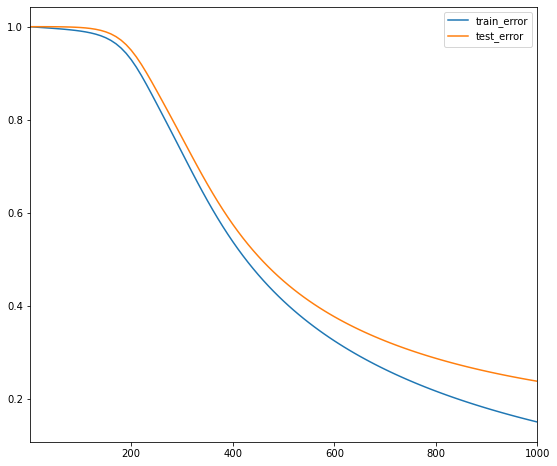

In [59]:
# Build the CF model and train it.
model = build_model(rating_matrix, num_queries=num_users, num_items=num_artists, embedding_dim=30, init_stddev=0.05)
model.train(num_iterations=1000, learning_rate=10.)

In the above graph, it can be observed that both `train_eror` and `test_error` are small values, indicating good performance of the model overall. However, we already know that the recommendations for this basic model will likely be poor.

Let's take a closer look at our embeddings. We'll view the embeddings near 'Adele'.

In [110]:
item_neighbors(model,title_substring="Adele", measure='dot', items=artists)
item_neighbors(model, title_substring="Adele", measure='cosine', items=artists)

Nearest neighbors of : Adele.


,dot score,name
1919,1.196,Adele
1444,1.168,Selena Gomez
334,1.164,Cher
518,1.161,Jeffree Star
303,1.153,Danity Kane
1449,1.152,Miranda Cosgrove


Nearest neighbors of : Adele.


,cosine score,name
1919,1.000,Adele
1444,0.954,Selena Gomez
1449,0.951,Miranda Cosgrove
518,0.950,Jeffree Star
532,0.950,Maroon 5
680,0.949,Selena Gomez & the Scene


### Current Model Predictions
At a glance, the embeddings closest to Adele seem reasonable, in the sense that they are all popular artist names that are somewhat familiar. This makes sense, Adele being one of the most popular artists in 2011. 

With basic recommendation systems, we often observe the appearance of 'niche' items (artists in our case) near our embeddings. This is due to the fact that these little-known artists can have a randomly assigned norm with a high value that is never corrected. We somewhat avoid this issue in our model generation by incorporating a relatively small `init_stddev` value of 0.05.

In [61]:
from CFUtils import tsne_item_embeddings, visualize_item_embeddings, item_embedding_norm, build_regularized_model

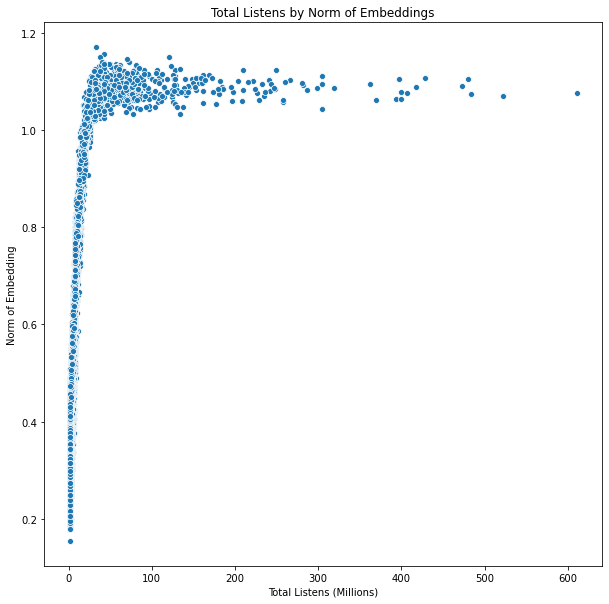

In [62]:
item_embedding_norm(model, artist_tot_listens, rating_matrix)

### Norm Analysis
Viewing the relation between the number of users who listen to an artist and that artist's norm, we see that our norm values are somewhat reasonable. The values seem to plateaux near the top. This results in lesser known artists unreasonably receiving higher norm values. Again, instantiating the norms using a normal distribution with a small standard deviation ensures that few niche artists receive high norms. This does not completely solve the issue.

To correct this behaviour, we can use regularization terms. Regularization terms introduce some bias in to our data which aims to reduce the impact of the behaviour previously discussed. We should expect to see less-performant error scores for our regularized model. This is okay however, as we should see improved recommendations being made.

---
## Regularisation
We'll now use two regularization techniques defined and discussed in our introduction section. Namely, *L2 Regularization*, and *Gravity Term* regularization. Essentially, these two terms aim to correct embeddings after they are initialised.

Our `build_regularized_model()` helper function defines both of our regularization terms and combines them into our `total_loss` function which is then provided to our `CFModel` class in place of the previous simplistic loss function. 

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
 iteration 2000: train_error_observed=0.296637, test_error_observed=0.326611, observed_loss=0.296637, regularization_loss=0.209359, gravity_loss=0.034404

[{'train_error_observed': 0.29663688, 'test_error_observed': 0.32661134},
 {'observed_loss': 0.29663688,
  'regularization_loss': 0.20935923,
  'gravity_loss': 0.034403637}]

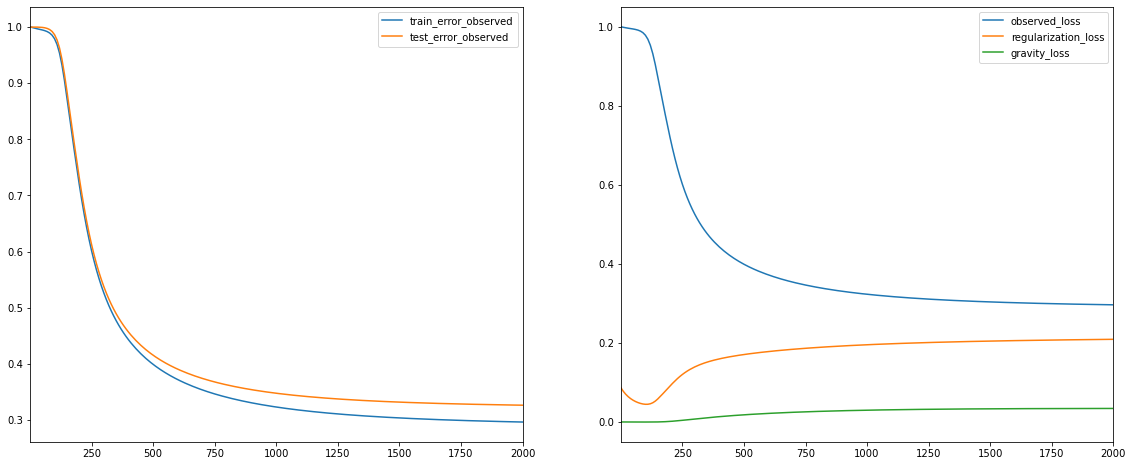

In [16]:
reg_model = build_regularized_model(
    rating_matrix, num_queries=num_users , num_items=num_artists, regularization_coeff=0.5,
    gravity_coeff=1.0, embedding_dim=35, init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

### Regularised Model Analysis
If we compare the graph on the left of our regularised model to the graph of our unregularised model, we can see that our regularised model has higher loss values. Higher loss values for an MF recommender system can be favourable to a certain degree. This is because our scoring functions ("DOT" and "COSINE") regularly make recommendations for items based on popularity. It's important for recommendation systems to include some type of personalisation in their recommendations, otherwise they will just recommend the most popular items to all users, which is useful to no one.

---

As before, we can now take a closer look at our embeddings. Let's once again view the embeddings near Adele, and try to interpret and compare them to our previous embeddings for our unregularised model. Let's first inspect the dot product as our measure, followed by cosine.

In [64]:
item_neighbors(reg_model,title_substring="Adele", measure='dot', items=artists)
item_neighbors(model,title_substring="Adele", measure='dot', items=artists)

Nearest neighbors of : Adele.


,dot score,name
83,4.443,Lady Gaga
61,4.409,Madonna
283,4.404,Britney Spears
282,4.375,Rihanna
294,4.375,Katy Perry
327,4.375,Avril Lavigne


Nearest neighbors of : Adele.


,dot score,name
1919,1.196,Adele
1444,1.168,Selena Gomez
334,1.164,Cher
518,1.161,Jeffree Star
303,1.153,Danity Kane
1449,1.152,Miranda Cosgrove


### Dot Product Comparison of Embeddings in Regularised and Unregularised
I think it's clear that although both models do make somewhat reasonable recommendations, the more appropriate embedding space is definitely found in the regularised model. The unregularised model seems to make less useful recommendations such as 'Miranda Cosgrove', and 'Jefree Star'. The regularised model returns popular, solo-female artists that may not make music exactly similar to Adele, but were equally as popular as Adele in 2011.

In [65]:
item_neighbors(model,title_substring="Adele", measure='cosine', items=artists)
item_neighbors(reg_model, title_substring="Adele", measure='cosine', items=artists)

Nearest neighbors of : Adele.


,cosine score,name
1919,1.000,Adele
1444,0.954,Selena Gomez
1449,0.951,Miranda Cosgrove
518,0.950,Jeffree Star
532,0.950,Maroon 5
680,0.949,Selena Gomez & the Scene


Nearest neighbors of : Adele.


,cosine score,name
1919,1.000,Adele
673,0.999,Glee Cast
542,0.999,Ellie Goulding
91,0.999,Duffy
1043,0.999,Pink
3061,0.999,Sara Bareilles


### Cosine Comparison of Embeddings in Regularised and Unregularised
We see a similar behaviour here, in that the regularised model embeddings are clearly more suitable. The appearance of *Glee Cast* as the most similar artist to Adele did seem like a strange recommendation. However, I found an [article](https://tvline.com/2011/11/17/glee-adele-rumor-has-it-someone-like-you/) that gives meaning to this recommendation. In 2011, Glee aired a mash-up of Adele's "Rumor Has It / Someone Like You" in one of their episodes which saw their iTunes song release reach No.1 on the charts.

Once again, we see the regularised model recommending popular solo-female artists from that time. Both cosine and dot product recommendations seem suitable for Adele.

---
## Norm Embedding Analysis
As previously, we will now view our model embeddings. We can see in the below image that the regularised model was able to break the plateaux previously observed in the unregularised model. As a result, this model is able to give more appropriate recommendations.

The below graph visually shows an improvement over our unregularised model. We see that embeddings no longer plateaux beyond a certain point, which leads to better recommendations.

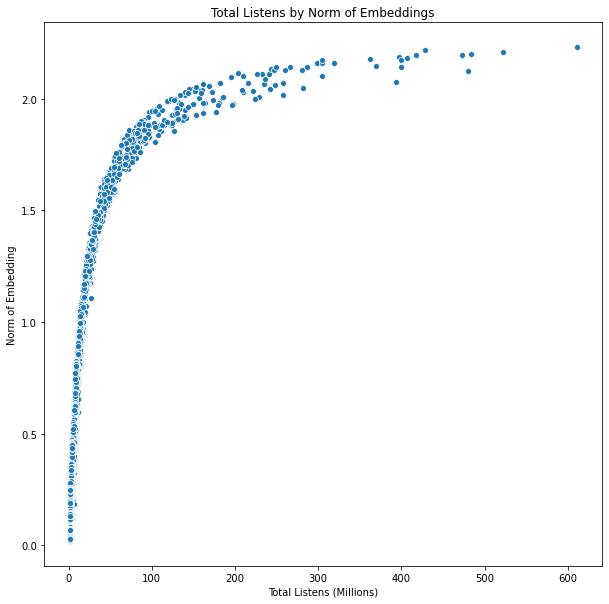

In [66]:
item_embedding_norm(reg_model, artist_tot_listens, rating_matrix)